In [1]:
"""make variations of input image"""

import argparse, os, sys, glob
import PIL
import torch
import torch.nn as nn
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
import time
from pytorch_lightning import seed_everything

sys.path.append(os.path.dirname(sys.path[0]))
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.to(device)
    model.eval()
    return model


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((512, 512), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

In [3]:
config="configs/stable-diffusion/v1-inference.yaml"
ckpt="models/sd/sd-v1-4.ckpt"
config = OmegaConf.load(f"{config}")
model = load_model_from_config(config, f"{ckpt}")
sampler = DDIMSampler(model)

Loading model from models/sd/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to C:\Users\56991/.cache\torch\hub\checkpoints\checkpoint_liberty_with_aug.pth


  0%|          | 0.00/5.10M [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.layer_norm1.weight', 'text_projection.weight', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.20.layer_norm2.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.23.mlp.fc2.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.bias', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.21.layer_norm2.weight', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.17.layer_norm2.bias', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.12.mlp.fc2.weight', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encode

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

In [4]:
def main(prompt = '', content_dir = '', style_dir='',ddim_steps = 50,strength = 0.5, model = None, seed=42):
    ddim_eta=0.0
    n_iter=1
    C=4
    f=8
    n_samples=1
    n_rows=0
    scale=10.0
    
    precision="autocast"
    outdir="outputs/img2img-samples"
    seed_everything(seed)


    os.makedirs(outdir, exist_ok=True)
    outpath = outdir

    batch_size = n_samples
    n_rows = n_rows if n_rows > 0 else batch_size
    data = [batch_size * [prompt]]


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) + 10
    
    style_image = load_img(style_dir).to(device)
    style_image = repeat(style_image, '1 ... -> b ...', b=batch_size)
    style_latent = model.get_first_stage_encoding(model.encode_first_stage(style_image))  # move to latent space

    content_name =  content_dir.split('/')[-1].split('.')[0]
    content_image = load_img(content_dir).to(device)
    content_image = repeat(content_image, '1 ... -> b ...', b=batch_size)
    content_latent = model.get_first_stage_encoding(model.encode_first_stage(content_image))  # move to latent space

    init_latent = content_latent

    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

    assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(strength * ddim_steps)
    print(f"target t_enc is {t_enc} steps")

    precision_scope = autocast if precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""], style_image)
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)

                        c= model.get_learned_conditioning(prompts, style_image)

                        # img2img

                        # stochastic encode
                        # z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))

                        # stochastic inversion
                        t_enc = int(strength * 1000) 
                        x_noisy = model.q_sample(x_start=init_latent, t=torch.tensor([t_enc]*batch_size).to(device))
                        model_output = model.apply_model(x_noisy, torch.tensor([t_enc]*batch_size).to(device), c)
                        z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device),\
                                                          noise = model_output, use_original_steps = True)
            
                        t_enc = int(strength * ddim_steps)
                        samples = sampler.decode(z_enc, c, t_enc, 
                                                unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=uc,)
                        print(z_enc.shape, uc.shape, t_enc)

                        # txt2img
            #             noise  =torch.randn_like(content_latent)
            #             samples, intermediates =sampler.sample(ddim_steps,1,(4,512,512),c,verbose=False, eta=1.,x_T = noise,
            #    unconditional_guidance_scale=scale,
            #    unconditional_conditioning=uc,)

                        x_samples = model.decode_first_stage(samples)

                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            base_count += 1
                        all_samples.append(x_samples)

                # additionally, save as grid
                grid = torch.stack(all_samples, 0)
                grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                grid = make_grid(grid, nrow=n_rows)

                # to image
                grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                output = Image.fromarray(grid.astype(np.uint8))
                output.save(os.path.join(outpath, content_name+'-'+prompt+f'-{grid_count:04}.png'))
                # Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                grid_count += 1

                toc = time.time()
    return output

In [7]:
# model.cpu()
model.embedding_manager.load('./models/sd/modern_embeddings.pt')
model = model.to(device)

find keys: dict_keys(['string_to_token', 'attention'])


Global seed set to 4


loaded input image of size (358, 353) from ./data/style.png
loaded input image of size (648, 631) from ./data/origin.jpg
target t_enc is 140 steps


data:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Running DDIM Sampling with 140 timesteps




Decoding image:   0%|                                                                          | 0/140 [00:00<?, ?it/s]

Decoding image:   1%|▍                                                                 | 1/140 [00:00<00:13, 10.00it/s]

Decoding image:   2%|█▍                                                                | 3/140 [00:00<00:13, 10.26it/s]

Decoding image:   4%|██▎                                                               | 5/140 [00:00<00:13, 10.34it/s]

Decoding image:   5%|███▎                                                              | 7/140 [00:00<00:12, 10.39it/s]

Decoding image:   6%|████▏                                                             | 9/140 [00:00<00:12, 10.38it/s]

Decoding image:   8%|█████                                                            | 11/140 [00:01<00:12, 10.36it/s]

Decoding image:   9%|██████                                                           | 13/140 [00:01<00:12, 10.37it/s]

Decoding image:  11%|██████▉  

torch.Size([1, 4, 64, 64]) torch.Size([1, 77, 768]) 140


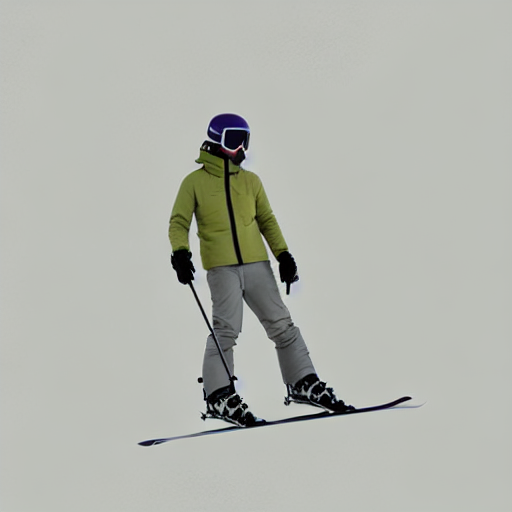

In [15]:
main(prompt = 'ski;colorful', \
     content_dir = './data/origin.jpg', \
     style_dir = './data/style.png', \
     ddim_steps = 200, \
     strength = 0.7, \
     seed=4, \
     model = model)